Breast cancer usually starts from an uncontrolled growth of the cells that make up the milk-producing ducts. Breast cancer doesn't develop over night and, like any other cancer, can be treated extremely effectively if detected in its earlier stages. Part of the understanding cancer is knowing that not all irregular cell growths are malignant; some are benign, or non-dangerous, non-cancerous growths. A benign tumor does not mean the mass doesn't increase in size, but only means it does not pose a threat to nearby tissue, nor is it likely to spread to other parts of the body. The mass simply stays wherever it's growing. Benign tumors are actually pretty popular, such as moles and some warts. Being able to properly assess if a tumor is actually benign and ignorable, or malignant and alarming is therefore of importance, and also is a problem that might be solvable through data and machine learning.

Here, we'll be using the Breast Cancer Wisconsin Original  data set, provided courtesy of UCI's Machine Learning Repository. 

We wills start by loading up the data and cleaning up the dataset. Once we have the data in the desired form, we will split it to do feature scaling since the features use different units, and then implement PCA and IsoMap and test the performance of both as the technique used to reduce the dimensionality of the dataset down to two variables.

We will then also train KNeighborsClassifier on the 2D projected training dataset and score KNeighborsClassifier on the 2D projected testing dataset. We will then plot the decision boundary for visual confirmation.

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn import manifold
from sklearn.preprocessing import Normalizer, MaxAbsScaler, MinMaxScaler, StandardScaler, RobustScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot') # Look Pretty

In [2]:
# True if test with PCA
Test_PCA = True

In [3]:
def plotDecisionBoundary(model, X, y):
    print ("Plotting...")
    
    fig = plt.figure()
    ax = fig.add_subplot(111)

    padding = 0.1
    resolution = 0.1

    #(2 for benign, 4 for malignant)
    colors = {2:'royalblue',4:'lightsalmon'} 


    # Calculate the boundaris
    x_min, x_max = X[:, 0].min(), X[:, 0].max()
    y_min, y_max = X[:, 1].min(), X[:, 1].max()
    x_range = x_max - x_min
    y_range = y_max - y_min
    x_min -= x_range * padding
    y_min -= y_range * padding
    x_max += x_range * padding
    y_max += y_range * padding

    # Creating a 2D Grid Matrix. The values stored in the matrix
    # are the predictions of the class at at said location
    import numpy as np
    xx, yy = np.meshgrid(np.arange(x_min, x_max, resolution),
                       np.arange(y_min, y_max, resolution))

    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # Plotting the contour map
    plt.contourf(xx, yy, Z, cmap=plt.cm.seismic)
    plt.axis('tight')

    # Plotting the testing points
    for label in np.unique(y):
        indices = np.where(y == label)
        plt.scatter(X[indices, 0], X[indices, 1], c=colors[label], alpha=0.8)

    p = model.get_params()
    plt.title('K = ' + str(p['n_neighbors']))
    plt.show()

In [4]:
# 
# Loading the dataset and setting proper headers.
df = pd.read_csv("Datasets/breast-cancer-wisconsin.data", header = None, names = ['sample', 'thickness', 'size', 'shape', 'adhesion', 'epithelial', 'nuclei', 'chromatin', 'nucleoli', 'mitoses', 'status'])
print(df.head(2))

    sample  thickness  size  shape  adhesion  epithelial nuclei  chromatin  \
0  1000025          5     1      1         1           2      1          3   
1  1002945          5     4      4         5           7     10          3   

   nucleoli  mitoses  status  
0         1        1       2  
1         2        1       2  


In [5]:
# Exploring the data
print(df.describe())

             sample   thickness        size       shape    adhesion  \
count  6.990000e+02  699.000000  699.000000  699.000000  699.000000   
mean   1.071704e+06    4.417740    3.134478    3.207439    2.806867   
std    6.170957e+05    2.815741    3.051459    2.971913    2.855379   
min    6.163400e+04    1.000000    1.000000    1.000000    1.000000   
25%    8.706885e+05    2.000000    1.000000    1.000000    1.000000   
50%    1.171710e+06    4.000000    1.000000    1.000000    1.000000   
75%    1.238298e+06    6.000000    5.000000    5.000000    4.000000   
max    1.345435e+07   10.000000   10.000000   10.000000   10.000000   

       epithelial   chromatin    nucleoli     mitoses      status  
count  699.000000  699.000000  699.000000  699.000000  699.000000  
mean     3.216023    3.437768    2.866953    1.589413    2.689557  
std      2.214300    2.438364    3.053634    1.715078    0.951273  
min      1.000000    1.000000    1.000000    1.000000    2.000000  
25%      2.000000   

In [6]:
# Checking the data types
print(df.dtypes)

sample         int64
thickness      int64
size           int64
shape          int64
adhesion       int64
epithelial     int64
nuclei        object
chromatin      int64
nucleoli       int64
mitoses        int64
status         int64
dtype: object


We make the following observations:
    1. nucleoli has a type of object even though it has just numbers 

In [7]:
# Treating the nuclei column to convert it back to numerical type
df.nuclei = pd.to_numeric(df.nuclei, errors="coerce")
print(df.dtypes)

sample          int64
thickness       int64
size            int64
shape           int64
adhesion        int64
epithelial      int64
nuclei        float64
chromatin       int64
nucleoli        int64
mitoses         int64
status          int64
dtype: object


In [8]:
# Checking for null values in the dataframe
print(df.isnull().values.any())
print (df[pd.isnull(df).any(axis=1)])

True
      sample  thickness  size  shape  adhesion  epithelial  nuclei  chromatin  \
23   1057013          8     4      5         1           2     NaN          7   
40   1096800          6     6      6         9           6     NaN          7   
139  1183246          1     1      1         1           1     NaN          2   
145  1184840          1     1      3         1           2     NaN          2   
158  1193683          1     1      2         1           3     NaN          1   
164  1197510          5     1      1         1           2     NaN          3   
235  1241232          3     1      4         1           2     NaN          3   
249   169356          3     1      1         1           2     NaN          3   
275   432809          3     1      3         1           2     NaN          2   
292   563649          8     8      8         1           2     NaN          6   
294   606140          1     1      1         1           2     NaN          2   
297    61634          5

In [9]:
#
# Treating nan values
df.nuclei = df.nuclei.fillna(df.nuclei.mean())
print(df.isnull().values.any())

False


In [10]:
# 
# Copying out the status column into a slice 
# and dropping the sample column since
# it will not play any important role in training
# our model.
status = df.status
print(len(df.status))
print(len(status))
df.drop(["status", "sample"], inplace = True, axis = 1)

699
699


In [11]:
# Now, that our data is ready, let us split into training and testing datasets
data_train, data_test, label_train, label_test = train_test_split(df, status, test_size = 0.5, random_state =7)

In [12]:
# Uncomment the only one set at a time and leave them commented to run without preprocessing

norm = Normalizer().fit(data_train)
maxabs = MaxAbsScaler().fit(data_train)
minmax = MinMaxScaler().fit(data_train)
stand = StandardScaler().fit(data_train)
robust = RobustScaler().fit(data_train)

#data_train = norm.transform(data_train)
#data_test = norm.transform(data_test)

#data_train = maxabs.transform(data_train)
#data_test = maxabs.transform(data_test)

data_train = minmax.transform(data_train)
data_test = minmax.transform(data_test)

#data_train = stand.transform(data_train)
#data_test = stand.transform(data_test)

#data_train = robust.transform(data_train)
#data_test = robust.transform(data_test)

Computing 2D Principle Components
0.9657142857142857
Plotting...


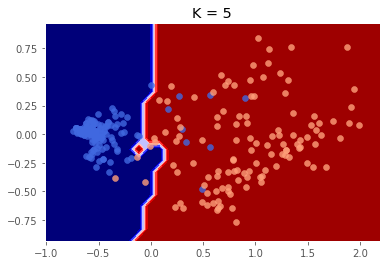

In [13]:
model = None
if Test_PCA:
    print ("Computing 2D Principle Components")
    model = PCA(n_components=2)

else:
    print ("Computing 2D Isomap Manifold")
    model = manifold.Isomap(n_components = 2, n_neighbors = 5)
    
# Training the model
model.fit(data_train)
data_train = model.transform(data_train)
data_test = model.transform(data_test)

# 
# Implementing and training KNeighborsClassifier on the projected 2D
# training data here.
knmodel = KNeighborsClassifier(n_neighbors = 5, weights='uniform')
knmodel.fit(data_train, label_train)
predict = knmodel.predict(data_test)

print(accuracy_score(label_test, predict))
plotDecisionBoundary(knmodel, data_test, label_test)